# Compute patches over land

From the NEMO mask, builds the coastline for nice plotting

Tested with **ORCA2.3** and **eORCA1.2**

Olivier Marti - olivier.marti@lsce.ipsl.fr - 2022/03/02

In [1]:
import numpy as np, xarray as xr
import nemo
import matplotlib.pyplot as plt
import matplotlib as mpl, cartopy.mpl.ticker
import cartopy.crs as ccrs, cartopy
import importlib, os
import matplotlib.patches as mpatches
from matplotlib.path import Path

# Choose ORCA config

In [2]:
f_Mask  = '/Users/marti/GRAF/DATA/ORCA2.3_coordinates_mask.nc' ; nperio = 4 ; Model = 'orca2.3' 
f_Coord = '/Users/marti/GRAF/DATA/coordinates_ORCA2.3.nc'

#f_Mask = '/Users/marti/GRAF/DATA/eORCA1.2_mesh_mask.nc' ; nperio = 6 ; Model = 'eorca1.2' ; f_Coord = f_Mask
#f_Mask  = '/Users/marti/GRAF/DATA/eORCA1.2_coordinates_mask.nc' ; nperio = 6 ; Model = 'eorca1.2'
#f_Coord = '/Users/marti/GRAF/DATA/coordinates_eORCA1.2.nc' 

#f_Mask = '/Users/marti/GRAF/DATA/orca2.3_lgm.nc' ; nperio=4 ; Model = 'orca2.3_lgm' ; f_Coord = f_Mask

#f_Mask  = '/Users/marti/GRAF/DATA/eORCA025_coordinates_mask.nc' ; nperio=6 ; Model='eORCA025'
#f_Coord = '/Users/marti/GRAF/DATA/eORCA025_coordinates.nc'

#f_Mask  = '/Users/marti/GRAF/DATA/eORCA1.4.2_ClosedSeasNew_ModifStraits_mesh_mask.nc' ; nperio=6.2 ; Model='eORCA1.4.2'
#f_Coord = '/Users/marti/GRAF/DATA/eORCA1.4.2_ClosedSeasNew_ModifStraits_domain_cfg.nc' 

## Reading the input file(s)

In [3]:
d_Mask = xr.open_dataset (f_Mask, decode_times=False).squeeze()
if f_Coord == f_Mask : d_Coord = d_Mask
else                 : d_Coord = xr.open_dataset (f_Coord, decode_times=False).squeeze()

In [4]:
dd =  xr.open_dataset ( 'orca2.3_coastline.nc' )
#dd = xr.open_dataset ('eORCA025_coastline.nc')
lat_coast = dd ['lat_coast']
lon_coast = dd ['lon_coast']

In [5]:
# Masks at center of the grid boxes
try : 
    maskC = xr.where ( d_Mask.tmask.isel(z=0)>0.5, 1.0, 0.0 ) 
except : 
    maskC = xr.where ( d_Mask.mask_T>0.5         , 1.0, 0.0 ) 
    
maskC = nemo.lbc (maskC, cd_type='T', nperio=nperio)

# Coordinates of the corners of the grid boxes
lonE = d_Coord.glamf ; latE = d_Coord.gphif
lonE = nemo.fixed_lon (lonE)

maskC = maskC.rename ( {maskC.dims[-2]:'y', maskC.dims[-1]:'x'} )
lonE  = lonE .rename ( {lonE .dims[-2]:'y', lonE .dims[-1]:'x'} )
latE  = latE .rename ( {latE .dims[-2]:'y', latE .dims[-1]:'x'} )

### If needed (for NEMO $\ge$ 4.2)

The algorithm needs that periodicity and north folding points are present
`nemo.lbc_add` adds this points for `nperio` in [4.2, 6.2].

In [6]:
if nperio == 4.2 or nperio == 6.2 :
    maskC = nemo.lbc_add (maskC, cd_type='T', nperio=nperio)
    lonE  = nemo.lbc_add (lonE , cd_type='F', nperio=nperio)
    latE  = nemo.lbc_add (latE , cd_type='F', nperio=nperio)
    if nperio == 4.2 : nperio = 4
    if nperio == 6.2 : nperio = 6
        
lonE = nemo.clo_lon (lonE, 0.)
jpj, jpi = maskC.shape

In [7]:
land_points = np.array (np.where (maskC==0)).transpose()

In [8]:
land_points.shape

(10362, 2)

In [9]:
poly_corners = [ ]

for point in land_points[3000:] :
    poly_corners.append ( np.array ([np.nan, np.nan]))
    j,i = point
   
    center_lon = lonE[j, i].item()
    
    poly_corners.append ( np.array( [center_lon                                     , latE[j  ,i  ].item()]) )
    poly_corners.append ( np.array( [nemo.clo_lon (lonE[j  ,i-1].item(), center_lon), latE[j  ,i-1].item()]) )
    poly_corners.append ( np.array( [nemo.clo_lon (lonE[j-1,i  ].item(), center_lon), latE[j-1,i  ].item()]) )  
    poly_corners.append ( np.array( [nemo.clo_lon (lonE[j-1,i-1].item(), center_lon), latE[j-1,i-1].item()]) )
    poly_corners.append ( np.array( [center_lon                                     , latE[j  ,i  ].item()]) )

poly_corners.append ( np.array ([np.nan, np.nan]))

poly_corners = np.array ( poly_corners )

In [10]:
poly_corners[10]

array([ 25.00121524, -10.04943344])

In [11]:
codes = np.zeros (len(poly_corners), dtype=int)
codes[ :] = Path.LINETO
codes[ 0] = Path.MOVETO
codes[-1] = Path.CLOSEPOLY

codes = np.where ( np.isnan(poly_corners[:,0]), Path.MOVETO, codes  )

path = Path (poly_corners, codes)

/Users/marti/mambaforge/envs/FULL/lib/python3.10/site-packages/shapely/creation.py:120: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


/Users/marti/mambaforge/envs/FULL/lib/python3.10/site-packages/shapely/creation.py:120: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


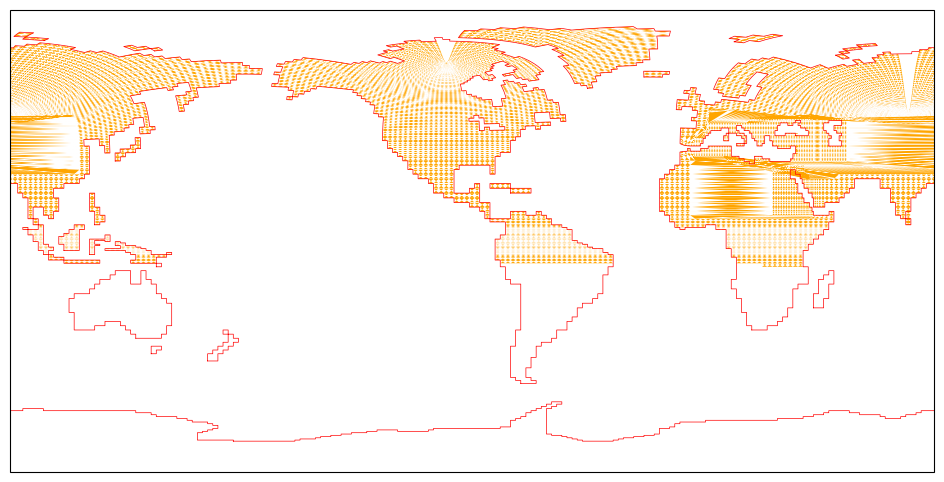

In [12]:
ProjIn = ccrs.PlateCarree(central_longitude=0)

ProjPlot = ccrs.PlateCarree               (central_longitude=270)
#ProjPlot = ccrs.Robinson                  (central_longitude=270)
#ProjPlot = ccrs.AzimuthalEquidistant      (central_longitude=270)
#ProjPlot = ccrs.InterruptedGoodeHomolosine(central_longitude=270)
#ProjPlot = ccrs.LambertAzimuthalEqualArea (central_longitude=270)
#ProjPlot = ccrs.AlbersEqualArea           (central_longitude=270)
#ProjPlot = ccrs.Stereographic             (central_longitude=270, central_latitude=40)
#ProjPlot = ccrs.Mollweide                 (central_longitude=270)
#ProjPlot = ccrs.NorthPolarStereo          (central_longitude=270)
#ProjPlot = ccrs.LambertConformal          (central_longitude=270, cutoff=-30)
#ProjPlot = ccrs.Orthographic              (central_longitude=270, central_latitude=90)
#ProjPlot = ccrs.EckertVI                  (central_longitude=270) 
#ProjPlot = ccrs.EquidistantConic          (central_longitude=270)
#ProjPlot = ccrs.RotatedPole      (pole_longitude=270, pole_latitude=60.0, central_rotated_longitude=270)

fig = plt.figure ( figsize=(18, 6) )

ax = fig.add_subplot (1, 1, 1, projection=ProjPlot)
    
ax.plot (lon_coast, lat_coast, linewidth=0.5, alpha=1, color='red' , transform=ProjIn)
ax.set_global()

patch = mpatches.PathPatch (path, facecolor='orange', lw=0, transform=ProjIn)
ax.add_patch (patch)


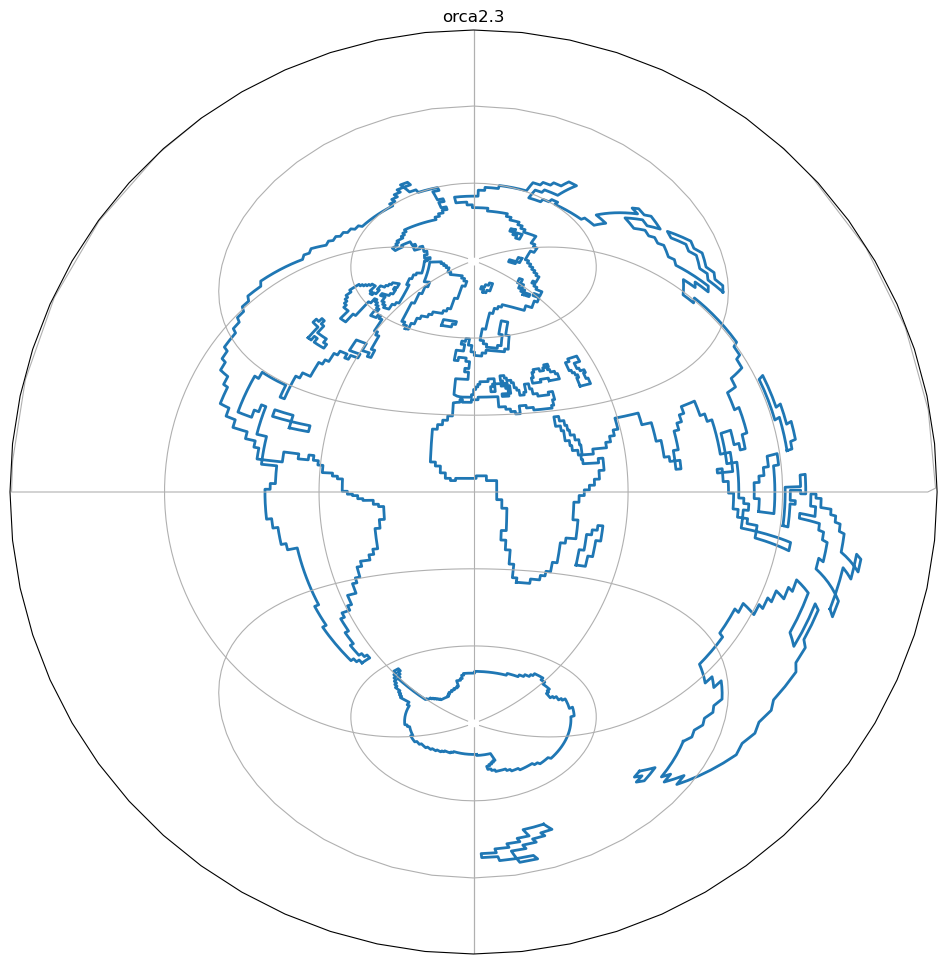

In [13]:
fig = plt.figure(figsize=(12,12))
ProjIn = ccrs.PlateCarree(central_longitude=0)
CenLon = 0

#ProjPlot=ccrs.PlateCarree(central_longitude=CenLon)
#ProjPlot=ccrs.Robinson(central_longitude=CenLon)
#ProjPlot=ccrs.Orthographic(central_longitude=CenLon, central_latitude=-90)
#ProjPlot=ccrs.Stereographic             (central_longitude=CenLon, central_latitude=90)
ProjPlot=ccrs.AzimuthalEquidistant      (central_longitude=CenLon)
#ProjPlot=ccrs.InterruptedGoodeHomolosine(central_longitude=CenLon)
#ProjPlot=ccrs.LambertAzimuthalEqualArea (central_longitude=CenLon)
#ProjPlot=ccrs.AlbersEqualArea           (central_longitude=CenLon), 
#ProjPlot=ccrs.Stereographic             (central_longitude=CenLon, central_latitude=40)
#ProjPlot=ccrs.Mollweide                 (central_longitude=CenLon)
#ProjPlot=ccrs.NorthPolarStereo          (central_longitude=CenLon)
#ProjPlot=ccrs.LambertConformal          (central_longitude=CenLon, cutoff=-30)
#ProjPlot=ccrs.Orthographic              (central_longitude=CenLon, central_latitude=90)
#ProjPlot=ccrs.EckertVI                  (central_longitude=CenLon)
#ProjPlot=ccrs.EquidistantConic          (central_longitude=CenLon)
#ProjPlot=ccrs.RotatedPole      (pole_longitude=CenLon, pole_latitude=60.0, central_rotated_longitude=lon0)
#ProjPlot=ccrs.RotatedPole      (pole_longitude=CenLon, pole_latitude= 0.0, central_rotated_longitude=lon0)

ax = fig.add_subplot (111, projection=ProjPlot)

ax.set_title (Model)
ax.plot (lon_coast, lat_coast, linewidth=2, transform=ProjIn)
ax.gridlines  ()
#ax.coastlines ()

ax.set_global()

#ax.fill (list_lon, list_lat, linewidth=1, transform=ProjIn)

#for nn in np.arange (np.max(list_land)) :
#    xlon = np.mean (list_lon[np.where(list_land==nn)])
#    ylat = np.mean (list_lat[np.where(list_land==nn)])
#    ax.annotate (str(nn), xy=[xlon,ylat], xycoords=ProjIn._as_mpl_transform(ax), fontsize='large', ha='center', va='center')
    

# Write the result